<a href="https://colab.research.google.com/github/MadmanMarble/Planet_U-NET/blob/main/Planet_U-NET_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 43.6 MB/s eta 0:00:00


In [3]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import rasterio
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.utils import Sequence, to_categorical
import numpy as np
import rasterio
import cv2
from keras.utils import to_categorical
import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from osgeo import gdal

In [4]:
# Ensure the lists are sorted so that images and labels correspond to each other
# load planet images
planet_images_1year = sorted(glob.glob(f"/content/drive/MyDrive/data/model_template/x_training/x_training_1year/*.tif"))
# load planet labels
planet_labels = sorted(glob.glob(f"/content/drive/MyDrive/data/model_template/y_training/*.tif"))

# Split the file paths into training and testing sets (80% train, 20% test)
train_images_paths, val_images_paths, train_labels_paths, val_labels_paths = train_test_split(
    planet_images_1year, planet_labels, test_size=0.20, random_state=58)

In [5]:
print("Total number of images:", len(planet_images_1year))
print("Total number of labels:", len(planet_labels))
print("Number of training images:", len(train_images_paths))
print("Number of training labels:", len(train_labels_paths))
print("Number of validation images:", len(val_images_paths))
print("Number of validation labels:", len(val_labels_paths))

Total number of images: 2305
Total number of labels: 2305
Number of training images: 1844
Number of training labels: 1844
Number of validation images: 461
Number of validation labels: 461


In [6]:
# Load training images and validation images to local to run faster.
# train_images_paths, val_images_paths, train_labels_paths, val_labels_paths
# 36 minutes
destination = '/content/train_images'
os.makedirs(destination, exist_ok=True)
for file in train_images_paths:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')


destination = '/content/train_labels'
os.makedirs(destination, exist_ok=True)
for file in train_labels_paths:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')

Copied /content/drive/MyDrive/data/model_template/x_training/x_training_1year/103_planet_stack_utm4.tif to /content/train_images/103_planet_stack_utm4.tif
Copied /content/drive/MyDrive/data/model_template/x_training/x_training_1year/1060_planet_stack_utm4.tif to /content/train_images/1060_planet_stack_utm4.tif
Copied /content/drive/MyDrive/data/model_template/x_training/x_training_1year/2429_planet_stack_utm4.tif to /content/train_images/2429_planet_stack_utm4.tif
Copied /content/drive/MyDrive/data/model_template/x_training/x_training_1year/829_planet_stack_utm4.tif to /content/train_images/829_planet_stack_utm4.tif
Copied /content/drive/MyDrive/data/model_template/x_training/x_training_1year/1733_planet_stack_utm4.tif to /content/train_images/1733_planet_stack_utm4.tif
Copied /content/drive/MyDrive/data/model_template/x_training/x_training_1year/1425_planet_stack_utm4.tif to /content/train_images/1425_planet_stack_utm4.tif
Copied /content/drive/MyDrive/data/model_template/x_training/x

In [7]:
# Load training images and validation images to local to run faster.
# train_images_paths, val_images_paths, train_labels_paths, val_labels_paths
# 7 minutes
destination = '/content/val_images'
os.makedirs(destination, exist_ok=True)
for file in val_images_paths:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')


destination = '/content/val_labels'
os.makedirs(destination, exist_ok=True)
for file in val_labels_paths:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')

Copied /content/drive/MyDrive/data/model_template/x_training/x_training_1year/2617_planet_stack_utm4.tif to /content/val_images/2617_planet_stack_utm4.tif
Copied /content/drive/MyDrive/data/model_template/x_training/x_training_1year/2560_planet_stack_utm4.tif to /content/val_images/2560_planet_stack_utm4.tif
Copied /content/drive/MyDrive/data/model_template/x_training/x_training_1year/388_planet_stack_utm4.tif to /content/val_images/388_planet_stack_utm4.tif
Copied /content/drive/MyDrive/data/model_template/x_training/x_training_1year/1705_planet_stack_utm4.tif to /content/val_images/1705_planet_stack_utm4.tif
Copied /content/drive/MyDrive/data/model_template/x_training/x_training_1year/1343_planet_stack_utm4.tif to /content/val_images/1343_planet_stack_utm4.tif
Copied /content/drive/MyDrive/data/model_template/x_training/x_training_1year/2055_planet_stack_utm4.tif to /content/val_images/2055_planet_stack_utm4.tif
Copied /content/drive/MyDrive/data/model_template/x_training/x_training_

In [8]:
train_images_paths = sorted(glob.glob(f"/content/train_images/*.tif"))
train_labels_paths = sorted(glob.glob(f"/content/train_labels/*.tif"))


val_images_paths = sorted(glob.glob(f"/content/val_images*.tif"))
val_labels_paths = sorted(glob.glob(f"/content/val_labels/*.tif"))

In [10]:
# prompt: User
# how can I find the unique number of classes within a folder of data, where each file within the folder is a different .tif file, and they may have different classes within them. for example, train_labels_paths is where my data is, and there could be 6 different classes in one file and 9 different classes in the next file.

import numpy as np
# Get a list of all the unique classes in the training labels folder
classes = []
for label_path in train_labels_paths:
    # Open the label file
    with rasterio.open(label_path) as label:
        # Get the unique classes in the label file
        unique_classes = np.unique(label.read(1))
        # Add the unique classes to the list
        classes.extend(unique_classes)

# Remove any duplicate classes from the list
classes = list(set(classes))

# Print the number of unique classes
print("Number of unique classes:", len(classes))
print(classes)

Number of unique classes: 13
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]


In [69]:
# prompt: convert type of classes from list to integer The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

import numpy as np
classes = np.array(classes).astype(int)


In [70]:
classes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [71]:
num_classes777 = classes

In [17]:
src_ds = gdal.Open(train_images_paths[155])
if src_ds is not None:
    print ("band count: " + str(src_ds.RasterCount))

src_ds = gdal.Open(train_labels_paths[155])
if src_ds is not None:
    print ("band count: " + str(src_ds.RasterCount))

band count: 5
band count: 1


In [22]:
# Inspect the train images dataset
src_ds = gdal.Open(train_images_paths[155])
if src_ds is not None:
    print("Band count:", src_ds.RasterCount)

    # Read the first band's data
    band = src_ds.GetRasterBand(5)
    band_data = band.ReadAsArray()

    # Find unique values in the band data
    unique_classes = np.unique(band_data)
    print("Unique classes:", unique_classes)

Band count: 5
Unique classes: [ 6.9893703  7.         7.000285  ... 29.865124  29.946957  30.174011 ]


In [41]:
# Inspect the train labels dataset
src_ds = gdal.Open(train_labels_paths[1700])
if src_ds is not None:
    print("Band count:", src_ds.RasterCount)

    # Read the first band's data
    band = src_ds.GetRasterBand(1)
    band_data_labels = band.ReadAsArray()

    # Find unique values in the band data
    unique_classes = np.unique(band_data_labels)
    print("Unique classes:", unique_classes)

Band count: 1
Unique classes: [ 1.  3.  4.  5.  6.  7.  8.  9. 10. 11.]


(384, 384)


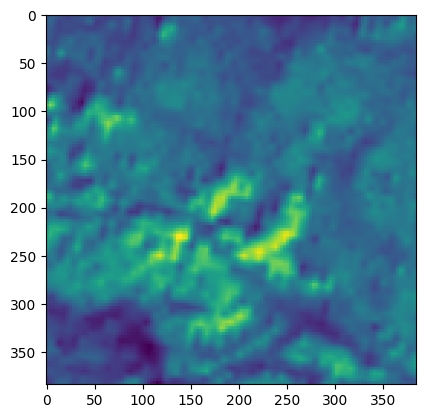

In [56]:
# What does one image and corresponding label look like?
dataset = gdal.Open(train_images_paths[155])
band = dataset.GetRasterBand(4) # band 4 to show NIR
array = band.ReadAsArray()
print(array.shape)
plt.imshow(array)

(384, 384)


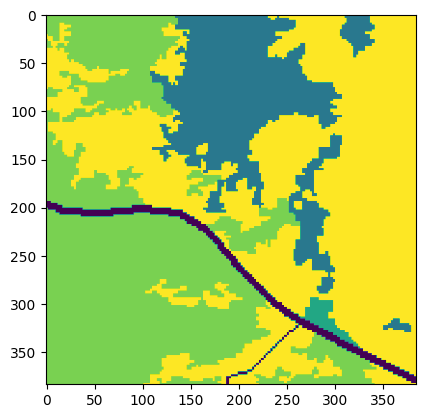

In [57]:
# What does one image and corresponding label look like?
dataset = gdal.Open(train_labels_paths[155])
band = dataset.GetRasterBand(1) # band 1 bc there is only 1 band
array = band.ReadAsArray()
print(array.shape)
plt.imshow(array)

In [80]:
class DataGenerator(Sequence):
    def __init__(self, image_files, label_files, img_height, img_width, batch_size, num_classes):
        self.image_files = image_files
        self.label_files = label_files
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = batch_size
        self.num_classes = num_classes

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        image_batch_files = self.image_files[index * self.batch_size : (index + 1) * self.batch_size]
        label_batch_files = self.label_files[index * self.batch_size : (index + 1) * self.batch_size]

        batch_images, batch_labels = self.load_images_and_labels(image_batch_files, label_batch_files)
        return batch_images, batch_labels

    def load_and_reshape_image(self, image_path):
        with rasterio.open(image_path) as src:
            image = src.read().transpose((1, 2, 0))
            if image.shape[:2] != (self.img_height, self.img_width):
                image = cv2.resize(image, (self.img_width, self.img_height), interpolation=cv2.INTER_NEAREST)
        return image


       # epsilon = 1e-7
        # mean = np.mean(image, axis=(0, 1), keepdims=True)
        # std = np.std(image, axis=(0, 1), keepdims=True)
        # std[std < 0] = 0
        # normalized_image = (image - mean) / (std + epsilon)

    def z_score_normalization(self, image):

        min = np.min(image, axis=(0, 1), keepdims=True)
        max = np.max(image, axis=(0, 1), keepdims=True)
        normalized_image = (image - min) / (max - min)
        return normalized_image

    # def z_score_normalization(self, image):
    #     image = image.astype(np.float32)  # Ensure the image is in float format to handle division and large ranges
    #     min_val = np.min(image, axis=(0, 1), keepdims=True)
    #     max_val = np.max(image, axis=(0, 1), keepdims=True)
    #     range_val = max_val - min_val
    #     if np.any(range_val == 0):
    #         normalized_image = np.zeros(image.shape, dtype=np.float32)
    #     else:
    #         normalized_image = (image - min_val) / range_val
    #     return normalized_image

# data = np.random.normal(loc=0, scale=1, size=(96108, 7, 7))
# data_min = np.min(data, axis=(1,2), keepdims=True)
# data_max = np.max(data, axis=(1,2), keepdims=True)
# scaled_data = (data - data_min) / (data_max - data_min)

    def load_images_and_labels(self, image_files, label_files):
        images = [self.load_and_reshape_image(image_file) for image_file in image_files]
        labels = [self.load_and_reshape_image(label_file) for label_file in label_files]

        # Apply Z-score normalization to images
        normalized_images = [self.z_score_normalization(image) for image in images]

        # Process labels if necessary (for example, converting to categorical)
        processed_labels = [to_categorical(label, num_classes=self.num_classes) for label in labels]

        return np.array(normalized_images), np.array(processed_labels)

In [72]:
SIZE_X = 384
SIZE_Y = 384
batch_size = 16
n_classes = 13

In [81]:
train_data_generator = DataGenerator(train_images_paths, train_labels_paths, SIZE_X, SIZE_Y, batch_size, n_classes)
val_data_generator = DataGenerator(val_images_paths, val_labels_paths, SIZE_X, SIZE_Y, batch_size, n_classes)

In [ ]:
# train_images_paths
# train_labels_paths

# val_images_paths
# val_labels_paths

In [82]:
batch_images, batch_labels = train_data_generator.__getitem__(0)

<ipython-input-80-996cf50cb959>:35: RuntimeWarning: invalid value encountered in divide
  normalized_image = (image - min) / (max - min)


In [83]:
batch_images

array([[[[0.7133891 , 0.7101968 , 0.72646534, 0.5942029 ,        nan],
         [0.7133891 , 0.7101968 , 0.72646534, 0.5942029 ,        nan],
         [0.7133891 , 0.7101968 , 0.72646534, 0.5942029 ,        nan],
         ...,
         [0.4832636 , 0.4847943 , 0.53641206, 0.4710145 ,        nan],
         [0.4832636 , 0.4847943 , 0.53641206, 0.4710145 ,        nan],
         [0.4832636 , 0.4847943 , 0.53641206, 0.4710145 ,        nan]],

        [[0.7133891 , 0.7101968 , 0.72646534, 0.5942029 ,        nan],
         [0.7133891 , 0.7101968 , 0.72646534, 0.5942029 ,        nan],
         [0.7133891 , 0.7101968 , 0.72646534, 0.5942029 ,        nan],
         ...,
         [0.4832636 , 0.4847943 , 0.53641206, 0.4710145 ,        nan],
         [0.4832636 , 0.4847943 , 0.53641206, 0.4710145 ,        nan],
         [0.4832636 , 0.4847943 , 0.53641206, 0.4710145 ,        nan]],

        [[0.7133891 , 0.7101968 , 0.72646534, 0.5942029 ,        nan],
         [0.7133891 , 0.7101968 , 0.72646534,

In [84]:
batch_labels

array([[[[0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         ...,
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.]],

        [[0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         ...,
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.]],

        [[0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         ...,
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         ...,
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
    

In [85]:
batch_images.shape

(16, 384, 384, 5)

In [86]:
batch_labels.shape

(16, 384, 384, 13)

In [ ]:
# def multi_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS=5, n_classes=13):
# #Build the model
#     inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#     s = inputs

#     #Contraction path
#     c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
#     c1 = Dropout(0.1)(c1)
#     c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
#     p1 = MaxPooling2D((2, 2))(c1)

#     c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
#     c2 = Dropout(0.1)(c2)
#     c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
#     p2 = MaxPooling2D((2, 2))(c2)

#     c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
#     c3 = Dropout(0.2)(c3)
#     c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
#     p3 = MaxPooling2D((2, 2))(c3)

#     c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
#     c4 = Dropout(0.2)(c4)
#     c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
#     p4 = MaxPooling2D(pool_size=(2, 2))(c4)

#     c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
#     c5 = Dropout(0.3)(c5)
#     c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#     #Expansive path
#     u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
#     u6 = concatenate([u6, c4])
#     c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
#     c6 = Dropout(0.2)(c6)
#     c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

#     u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
#     u7 = concatenate([u7, c3])
#     c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
#     c7 = Dropout(0.2)(c7)
#     c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

#     u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
#     u8 = concatenate([u8, c2])
#     c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
#     c8 = Dropout(0.1)(c8)
#     c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

#     u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
#     u9 = concatenate([u9, c1], axis=3)
#     c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
#     c9 = Dropout(0.1)(c9)
#     c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

#     outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c9)

#     model = Model(inputs=[inputs], outputs=[outputs])

#     return model

In [87]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (5,))  # Add number of channels: 5

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()


In [88]:
model = get_model(img_size=(SIZE_X, SIZE_Y), num_classes=13)

In [90]:
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 384, 384, 5), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [91]:
print(model.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 384, 384, 13), dtype=tf.float32, name=None), name='conv2d_8/Softmax:0', description="created by layer 'conv2d_8'")


In [89]:
print(model.summary()) # 1year: 2,062,445

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 384, 384, 5)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 192, 192, 32)         1472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 192, 192, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 192, 192, 32)         0         ['batch_normalization[0][0

In [ ]:
# model = get_model(IMG_HEIGHT=SIZE_X, IMG_WIDTH=SIZE_Y, IMG_CHANNELS=5, n_classes=13)

In [92]:
import numpy as np
import cv2
import os
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback
import rasterio

class SavePredictionCallback(Callback):
    def __init__(self, test_image_dir, test_label_dir, model_input_size, output_folder, epoch_frequency=5):
        super().__init__()
        self.test_image_dir = test_image_dir
        self.test_label_dir = test_label_dir  # Optional: Use if you want to compare predictions with actual labels
        self.model_input_size = model_input_size
        self.output_folder = output_folder
        self.epoch_frequency = epoch_frequency
        self.image_files = [os.path.join(test_image_dir, f) for f in os.listdir(test_image_dir) if f.endswith('.tif')]

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.epoch_frequency == 0:
            for image_path in self.image_files:
                with rasterio.open(image_path) as src:
                    image = src.read(out_shape=(src.count, self.model_input_size[0], self.model_input_size[1]),
                                     resampling=rasterio.enums.Resampling.nearest)
                    image = np.transpose(image, (1, 2, 0))
                    image = np.expand_dims(image, axis=0)  # Add batch dimension
                    image = image / np.max(image)  # Normalize
                    meta = src.meta

                prediction = self.model.predict(image)
                prediction_image = np.argmax(prediction, axis=-1)[0, :, :]

                output_path = os.path.join(self.output_folder, f"epoch_{epoch+1}_{os.path.basename(image_path)}")
                meta = src.meta
                meta.update(dtype=rasterio.uint8, count=1, nodata=None)  # what was here previously: (dtype=rasterio.uint8, count=1)

                with rasterio.open(output_path, 'w', **meta) as dst:
                    dst.write(prediction_image.astype(rasterio.uint8), 1)

# model = get_model(img_size=(SIZE_X, SIZE_Y), num_classes=13)

# Define model input size and paths
IMG_HEIGHT, IMG_WIDTH = SIZE_X, SIZE_Y
test_image_dir = '/content/drive/MyDrive/data/model_template/x_test/x_test_1year/'
test_label_dir = '/content/drive/MyDrive/data/model_template/y_test/'
output_folder = '/content/drive/MyDrive/data/model_outputs/model_1year_0329/'

# Make sure the output directory exists
os.makedirs(output_folder, exist_ok=True)

# Instantiate the callback
save_pred_callback = SavePredictionCallback(
    test_image_dir=test_image_dir,
    test_label_dir=test_label_dir,
    model_input_size=(IMG_HEIGHT, IMG_WIDTH),
    output_folder=output_folder,
    epoch_frequency=5
)

# Include this callback in your model's fit method along with other callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath='model_1year_0329.h5', save_best_only=True),
    save_pred_callback
]

# Example model.fit call
# model.fit(train_data_generator, validation_data=val_gen, epochs=100, callbacks=callbacks)



In [93]:
model.compile(optimizer= Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy', "categorical_accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath='model_1year_0329.h5', save_best_only=True),
    save_pred_callback
]

In [94]:
model.fit(train_data_generator, validation_data=val_data_generator, epochs=5, callbacks=callbacks)

<ipython-input-80-996cf50cb959>:35: RuntimeWarning: invalid value encountered in divide
  normalized_image = (image - min) / (max - min)


Epoch 1/5


<ipython-input-80-996cf50cb959>:35: RuntimeWarning: invalid value encountered in divide
  normalized_image = (image - min) / (max - min)
<ipython-input-80-996cf50cb959>:35: RuntimeWarning: invalid value encountered in divide
  normalized_image = (image - min) / (max - min)


KeyboardInterrupt: 